# Heatmap compsoed model
 - heatmap-edge2.pth


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os

In [3]:
import pickle

class HeatmapDataset(Dataset):
    """My dataset."""

    def __init__(self, pickle_path, transform=None, n_sample=None):
        super(HeatmapDataset, self).__init__()
        self.pickle_path = pickle_path
        self.transform = transform
        self.upsample = nn.UpsamplingBilinear2d([224,224])
        
        # load
        with open(pickle_path, 'rb') as f:
            data = pickle.load(f)
            self.boxes_data = data['boxes'] # n_box, 4
            self.heatmap_data = data['heatmaps'] # cls,ch,h,w tensor
            self.origTargets = data['targets'] # 
            self.sobels = data['sobels'] # 1,224,224 tensor
            
#         # n개만 샘플링 - validation용
#         if(n_sample is not None):
#             sample_indices = np.random.choice(len(self.heatmap_data), n_sample, replace=False)
#             self.boxes_data = self.boxes_data[sample_indices]
#             self.heatmap_data = self.heatmap_data[sample_indices]
#             self.origTargets = self.origTargets[sample_indices]
#             self.sobels = self.sobels[sample_indices] 

        self.origTargetSet = list(set(np.concatenate(self.origTargets)))
        self.origTarget2newTarget = {t:i for i,t in enumerate(self.origTargetSet)}
        self.n_classes = len(self.origTarget2newTarget)
        assert len(self.heatmap_data)==len(self.boxes_data), "num_heatmap != num_box"

    def __len__(self):
        return len(self.heatmap_data)

    def __getitem__(self, idx):
        bboxes = torch.tensor(self.boxes_data[idx])
        targets = torch.tensor([self.origTarget2newTarget[t] for t in self.origTargets[idx]])
#         sobels = torch.stack([self.sobels[idx]]*self.n_classes) # cls, 1, 224, 224
        
        heatmap = self.heatmap_data[idx][self.origTargetSet]
        heatmap = self.upsample(heatmap) # cls, ch, 224, 224 - 4d tensor
#         heatmap = torch.cat([heatmap, sobels], dim=1) # cls, ch+1, 224, 224 - 4d tensor
        
        if self.transform:
            heatmap = self.transform(heatmap).unsqueeze(0)

        one_hot = torch.zeros(len(targets), self.n_classes)
        one_hot[torch.arange(len(targets)), targets] = 1
        return heatmap.float(), bboxes.float(), one_hot

In [3]:
pickle_path = 'heatmap_voc_multi_1203.pickle'
pickle_val_path = 'heatmap_voc_multi_1203_val.pickle'

my_dataset = HeatmapDataset(pickle_path)
my_dataset_val = HeatmapDataset(pickle_val_path)#, n_sample=100)


my_loader = torch.utils.data.DataLoader(my_dataset, batch_size=1, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)
my_loader_val = torch.utils.data.DataLoader(my_dataset_val, batch_size=1, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)


dataloaders = {
    'train': my_loader,
    'val': my_loader_val
}
dataset_sizes = {
    'train': len(my_dataset),
    'val': len(my_dataset_val)
}

print(dataset_sizes)

{'train': 7100, 'val': 284}


In [4]:
my_dataset[8][0].shape, my_dataset[8][1].shape, my_dataset[8][2], my_dataset.origTarget2newTarget

(torch.Size([11, 5, 224, 224]),
 torch.Size([1, 4]),
 tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]),
 {0: 0, 1: 1, 2: 2, 6: 3, 7: 4, 9: 5, 11: 6, 12: 7, 13: 8, 16: 9, 18: 10})

In [5]:
def IOU_loss(ious):
    """
    @params ious - N length tensor
    배치 하나당 0.3 정도가 약 0.5 IOU
    """
    loss = -1 * (ious +1e-9).log() 
    return loss.sum()

def cvt_yolobox_tensor(bboxes_yolo, size):
    """
    size - original [w,h]
    np.array
    yolo(cx,cy,w,h) to x,y,x2,y2
    """
    bboxes = bboxes_yolo.clone() # x,y,w,h

    bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*size[1] # x
    bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*size[0] # y
    bboxes[:,2] = bboxes_yolo[:,2]*size[1] + bboxes[:,0]
    bboxes[:,3] = bboxes_yolo[:,3]*size[0] + bboxes[:,1]
    return bboxes


In [6]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torchvision
# from RoIAlign.roi_align import RoIAlign      # RoIAlign module
# from RoIAlign.roi_align import CropAndResizeFunction # crop_and_resize module
import cv2
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
        
class BoxMaker(nn.Module):
    def __init__(self):
        super(BoxMaker, self).__init__()
        global_average_pooling = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten()
        self.roi_upsample = nn.UpsamplingBilinear2d([224,224])
        
        # backbone layer
        self.backbone = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(5, 32, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # b*cls x 256 x 14 x 14
#             global_average_pooling, # n x 256 x 1 x 1
#             flatten, # n x 256
        )
        
        self.backbone2 = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(5, 32, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # b*cls x 256 x 14 x 14
#             global_average_pooling, # n x 256 x 1 x 1
#             flatten, # n x 256
        )
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8)
                        
        self.fc = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(512, 256, kernel_size=(1,1), stride=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.Conv2d(256, 5, kernel_size=(1,1), stride=(1, 1)),
            nn.BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),            
        )
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        
    def forward(self, inputs):
        """
        inputs - 1,cls,ch,224,224
        디텍터는 한번에 한 프레임밖에 안됨
        """
        # CNN backbone
        images = inputs[0] # cls,ch,224,224
        
        hh = self.backbone(images) # cls x 256 x 14 x 14
        hh2 = self.backbone2(images) # cls x 256 x 14 x 14
        
        hh = hh.reshape(-1, 256, 196) # cls x 256 x 196
        hh2 = hh2.reshape(-1, 256, 196) # cls x 256 x 196
        
        hh3 = torch.cat([hh,hh2], dim=1) # cls x 512 x 196
        hh3 = hh3.transpose(1,2) # cls x 196 x 512
        
        attn_output, attn_output_weights = self.multihead_attn(hh3, hh3, hh3) # q,k,v - Seq,Batch,Embed - cls,196,512       
        attn_sum = hh3+attn_output # cls x 196 x 512
        
        res = attn_sum.transpose(1,2) # cls x 512 x 196

        res2 = res.reshape(-1,512, 14, 14) # cls x 512 x 14 x 14 - for conv 
        
        pp = self.fc(res2) # cls x 5(1+4) x 14 x 14
        pp = pp.transpose(2,1) # cls x 14 x 14 x 5(1+4)
        pp = pp.reshape(-1,196,5)
        logit = pp[:,:,0] # cls x 196
        coords = pp[:,:,1:] # cls x 196 x 4
        
        return logit, coords

In [7]:
def yolo2xxyy(boxes_gt):
    # yolo box to (x1,y1,x2,y2)
    boxes_gt_xxyy = torch.rand_like(boxes_gt) # cx,cy,w,h
    boxes_gt_xxyy[:,0] = boxes_gt[:,0] - boxes_gt[:,2]/2
    boxes_gt_xxyy[:,1] = boxes_gt[:,1] - boxes_gt[:,3]/2
    boxes_gt_xxyy[:,2] = boxes_gt[:,0] + boxes_gt[:,2]/2
    boxes_gt_xxyy[:,3] = boxes_gt[:,1] + boxes_gt[:,3]/2
    return boxes_gt_xxyy # x1,y1,x2,y2

# make 14x14 center coords
x_range = np.linspace(0,1,14+1)
X, Y = np.meshgrid(x_range,x_range)
C = np.array([list(zip(x, y)) for x, y in zip(X, Y)])
EDGES = C[:14,:14].reshape(-1,2)

CC = []
for x in range(C.shape[0]-1):
    for y in range(C.shape[1]-1):
        CC.append((C[x][y]+C[x+1][y+1])/2) # x1,y1,x2,y2
CENTERS = np.array(CC)
INTERVAL = 1/14

criterion_logit = nn.BCEWithLogitsLoss(reduction='sum') # N x cls (one-hot)
def criterion_coord(boxes_pred, boxes_gt, weights=None):
    """
    boxes - N x 4 :  cx,cy,w,h (normalized like Yolo data)
    weights - N
    """
    # bbox coord loss
    _loss = (boxes_pred-boxes_gt).pow(2)
    if(weights is not None):
        _weight = weights.repeat([4,1]).transpose(0,1) # N x 4
        _loss = _loss * _weight
    
    loss_xy = _loss[:,:2] *500
    loss_wh = _loss[:, 2:] *100 
    return loss_xy.mean(), loss_wh.mean()

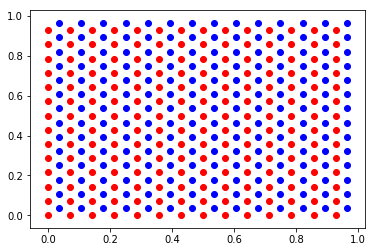

In [8]:
plt.scatter(EDGES[:,0], EDGES[:,1], c='r')
plt.scatter(CENTERS[:,0], CENTERS[:,1], c='b')
plt.show()

In [10]:
load = iter(my_loader)
# 어차피 batch=1 이므로
heatmap, boxes_gt, targets_gt = next(load)
heatmap = heatmap.cuda()
boxes_gt = boxes_gt[0].cuda()
targets_gt = targets_gt[0].cuda()
heatmap.shape, boxes_gt.shape, targets_gt.shape, targets_gt

(torch.Size([1, 11, 5, 224, 224]),
 torch.Size([1, 4]),
 torch.Size([1, 11]),
 tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0'))

In [13]:
# model inference
logits, boxes_pred = model(heatmap)
boxes_pred_selected = boxes_pred[boxes_gt.argmax(dim=1)] # 모델이 예측한 값중 정답 클래스의 박스값들
boxes_pred.shape, boxes_pred_selected.shape

(torch.Size([11, 196, 4]), torch.Size([1, 196, 4]))

In [14]:
%%time
# mask, weight 생성
masks = []
weights = []
boxes_gt_xxyy = yolo2xxyy(boxes_gt)
for i in range(len(boxes_gt)):
#     mask = (CENTERS[:,0]>boxes_gt_xxyy[i][0].item())&(CENTERS[:,0]<=boxes_gt_xxyy[i][2].item())&(CENTERS[:,1]>boxes_gt_xxyy[i][1].item())&(CENTERS[:,1]<=boxes_gt_xxyy[i][3].item())
    mask = (EDGES[:,0]>boxes_gt_xxyy[i][0].item()-INTERVAL)&(EDGES[:,0]<=boxes_gt_xxyy[i][2].item())&(EDGES[:,1]>boxes_gt_xxyy[i][1].item()-INTERVAL)&(EDGES[:,1]<=boxes_gt_xxyy[i][3].item())
    weight = np.apply_along_axis(lambda c: (1 - np.linalg.norm(c-boxes_gt[i][:2].cpu().numpy())), 1, CENTERS)
    masks.append(mask)
    weights.append(weight)
masks = torch.tensor(masks).cuda()
weights = torch.tensor(weights).pow(4).cuda() # 거리 4제곱 반비례 [0~1]

Wall time: 32 ms


In [37]:
loss = torch.tensor(0).double().cuda()
for i in range(len(targets_gt)):
    # 동적으로 가중치 변경해가며 BCE loss
    loss_l = torch.tensor(0).double().cuda()
    for p,g,w in zip(logits[:, masks[i]].transpose(0,1), targets_gt[i].repeat(masks.sum(dim=1)[i],1), weights[i][masks[i]]):
        l = criterion_logit(p,g)*w
        loss_logit += l
    loss_xy, loss_wh = criterion_coord(boxes_pred_selected[i][masks[i]], boxes_gt[i].repeat(masks.sum(dim=1)[i],1), weights[i][masks[i]])
    loss = loss + loss_logit +loss_xy + loss_wh

tensor(290.2226, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor(206.1593, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor(74.4803, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) tensor(9.5831, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


In [38]:
loss#.backward()

tensor(290.2226, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

In [244]:
# logits[:, masks[i]].transpose(0,1).shape, targets_gt[i].repeat(masks.sum(dim=1)[i],1).shape
# boxes_pred_selected[i][masks[i]].shape, boxes_gt[i].repeat(masks.sum(dim=1)[i],1).shape, weights[i][masks[i]].shape 

(torch.Size([4, 11]), torch.Size([4, 11]))

In [320]:
# for p,g,w in zip(logits[:, masks[i]].transpose(0,1), targets_gt[i].repeat(masks.sum(dim=1)[i],1), weights[i][masks[i]]):
#     l = criterion_logit(p,g)*w
#     print(l)

tensor(6.0912, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(8.8757, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(6.6158, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(14.7282, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


---
#  
#  
# -----

In [12]:
from torchsummary import summary
model = BoxMaker()
model.to(model.device)
# summary(model, (2, 5, 224, 224))

BoxMaker(
  (roi_upsample): UpsamplingBilinear2d(size=[224, 224], mode=bilinear)
  (backbone): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2

In [9]:
import time 
import copy

def train_model(model, criterion_logit, criterion_coord, optimizer, num_epochs=25):
    global loss_list_train, loss_list_val, best_model_wts

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    prev_val_loss = float('inf')
    val_cnt = 0 # val loss 커진 횟수
    decrease_cnt = 0 # lr 줄인 횟수

    for epoch in range(num_epochs):
        since = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_loss_logit = 0.0
            running_loss_xy = 0.0
            running_loss_wh = 0.0
            running_corrects = 0
            # Iterate over data.
            for idx, (inputs, boxes_gt, targets) in enumerate(dataloaders[phase]):
                inputs = inputs.to(model.device) # 1 x cls x ch x 224 x 224 
                boxes_gt = boxes_gt.to(model.device)[0] # n x 4
                targets = targets.to(model.device)[0] # n x cls

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    logits, boxes_pred = model(inputs)
                    _, preds = torch.max(logits, 1)
                    __, target_labels = torch.max(targets, 1)
                    
                    right_indices = preds == target_labels # 정답 레이블 맞춘것
                    right_targets = target_labels[right_indices]
#                     print('<<>>', right_targets, right_indices)
                    
                    loss_xy, loss_wh = criterion_coord(boxes_pred[torch.arange(len(logits)), target_labels], boxes_gt, epoch)
                    loss_logit = criterion_logit(logits, targets)
                    loss = loss_logit + loss_xy + loss_wh

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss_logit += loss_logit.item()
                running_loss_xy += loss_xy.item()
                running_loss_wh += loss_wh.item()
                running_loss += loss.item()
                running_corrects += (preds == target_labels).sum().item()
                
                # mini batch statistics
                if idx>0 and idx%10==0:
                    cnt = idx*dataloaders[phase].batch_size
                    print('[batch]{}, {} Loss_l: {:.4f}, Loss_xy: {:.4f}, Loss_wh: {:.4f}, Acc: {:.4f}'.format(
                        cnt, phase, running_loss_logit/cnt, running_loss_xy/cnt, running_loss_wh/cnt, running_corrects/cnt))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            # detail
            loss_xy_list[phase].append(running_loss_xy/dataset_sizes[phase])
            loss_wh_list[phase].append(running_loss_wh/dataset_sizes[phase])
            loss_logit_list[phase].append(running_loss_logit/dataset_sizes[phase])            
            # all
            loss_list[phase].append(epoch_loss)
            acc_list[phase].append(epoch_acc)

            print('{} Loss: {:.4f}, Acc: {:.4f}, lr: {}, BestLoss: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, optimizer.param_groups[0]['lr'], best_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
#             # for lr decay
#             if phase == 'val' and epoch_loss < prev_val_loss:
                val_cnt = 0                
            elif phase == 'val' and epoch_loss >= best_loss:
                val_cnt += 1
            
            if phase == 'val':
                prev_val_loss = epoch_loss
                
        # decay 0.2 per 2 chance        
        if(val_cnt==3):  # 2번 안내려가면 러닝레이트 내림
            val_cnt = 0
            decrease_cnt += 1
            for g in optimizer.param_groups:
                g['lr'] = g['lr']*0.2
                print('****** lr decrease ******')
                print('[decrease_cnt]:', decrease_cnt, ', [lr]:', g['lr'])
                print('[Load best weight]')
                model.load_state_dict(best_model_wts)
                
        if(decrease_cnt==5): # 학습 멈춤
            print('###### early stop #####')
            break
            

        time_elapsed = time.time() - since
        print('Training epoch duration is {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# model.load_state_dict(torch.load('torch_models/heatmap-edge2.pth'))

In [339]:
?nn.BCEWithLogitsLoss
# target.shape

In [116]:
    >>> target = torch.ones([10, 64], dtype=torch.float32)  # 64 classes, batch size = 10
    >>> output = torch.full([10, 64], 0.999)  # A prediction (logit)

In [83]:
criterion_logit = nn.BCEWithLogitsLoss(reduction='sum') # N x cls (one-hot)

def criterion_coord(boxes_pred, boxes_gt, epoch):
    """
    boxes - N x 4 :  cx,cy,w,h (normalized like Yolo data)
    """
    # bbox coord loss
    _loss = (boxes_pred-boxes_gt).pow(2)
    
#     if(epoch==0):
#         loss_ratio = torch.tensor(0.0)
#     else:
#         r_gt = boxes_gt[:,2]/boxes_gt[:,3]
#         r_pred = boxes_pred[:,2]/boxes_gt[:,3]
#         loss_ratio = (r_gt/r_pred).log().abs()*10

#     _boxes_pred = boxes_pred.clone().detach()
#     for_small_weight = (_boxes_pred[:,2]*_boxes_pred[:,3]).pow(-1/2)
    
#     #번갈아가며 가중치 변경 하다가 12epoch 후엔 동시에
#     if(epoch>=8):
#         loss_xy = _loss[:,:2] *250
#         loss_wh = _loss[:, 2:] *250
#     elif(epoch%4<2): 
#         loss_xy = _loss[:,:2] *500
#         loss_wh = _loss[:, 2:]
#     else: 
#         loss_xy = _loss[:,:2]
#         loss_wh = _loss[:, 2:] *500
        
    loss_xy = _loss[:,:2] *500
    loss_wh = _loss[:, 2:] *100 
    return loss_xy.sum(), loss_wh.sum()#, loss_ratio.sum()#.mul(for_small_weight).sum()

In [12]:
loss_xy_list = {'train':[], 'val':[]}
loss_wh_list = {'train':[], 'val':[]}
loss_logit_list = {'train':[], 'val':[]}

loss_list = {'train':[], 'val':[]}
acc_list = {'train':[], 'val':[]}
best_model_wts = None

# Observe that only parameters of final layer are bkeing optimized as
# optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 3 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [13]:
# Set seed
torch.manual_seed(777)
model = train_model(model, criterion_logit, criterion_coord, optimizer, num_epochs=50)

Epoch 1/50
----------
[batch]80, train Loss_l: 8.0569, Loss_xy: 74.2926, Loss_wh: 22.1987, Acc: 0.5750
[batch]160, train Loss_l: 6.9884, Loss_xy: 42.5720, Loss_wh: 16.4979, Acc: 0.7125
[batch]240, train Loss_l: 6.3378, Loss_xy: 32.6386, Loss_wh: 13.8988, Acc: 0.7750
[batch]320, train Loss_l: 5.9177, Loss_xy: 27.2439, Loss_wh: 13.1821, Acc: 0.8156
[batch]400, train Loss_l: 5.5811, Loss_xy: 25.0787, Loss_wh: 12.4178, Acc: 0.8425
[batch]480, train Loss_l: 5.2358, Loss_xy: 23.1722, Loss_wh: 11.6107, Acc: 0.8542
[batch]560, train Loss_l: 4.9742, Loss_xy: 21.2218, Loss_wh: 11.1284, Acc: 0.8714
[batch]640, train Loss_l: 4.7589, Loss_xy: 20.4493, Loss_wh: 10.8823, Acc: 0.8734
[batch]720, train Loss_l: 4.5625, Loss_xy: 19.8776, Loss_wh: 10.5749, Acc: 0.8694
[batch]800, train Loss_l: 4.4101, Loss_xy: 18.9436, Loss_wh: 10.5352, Acc: 0.8125
[batch]880, train Loss_l: 4.2466, Loss_xy: 18.2421, Loss_wh: 10.4794, Acc: 0.8193
[batch]960, train Loss_l: 4.0958, Loss_xy: 17.8117, Loss_wh: 10.2277, Acc: 0.

[batch]320, train Loss_l: 0.3979, Loss_xy: 4.8759, Loss_wh: 4.3434, Acc: 0.9906
[batch]400, train Loss_l: 0.4554, Loss_xy: 4.6034, Loss_wh: 4.2433, Acc: 0.9775
[batch]480, train Loss_l: 0.4789, Loss_xy: 4.7383, Loss_wh: 4.1514, Acc: 0.9771
[batch]560, train Loss_l: 0.4814, Loss_xy: 4.7449, Loss_wh: 4.4173, Acc: 0.9732
[batch]640, train Loss_l: 0.6204, Loss_xy: 5.2786, Loss_wh: 4.4512, Acc: 0.9656
[batch]720, train Loss_l: 0.6415, Loss_xy: 5.7620, Loss_wh: 4.4974, Acc: 0.9625
[batch]800, train Loss_l: 0.6735, Loss_xy: 5.8559, Loss_wh: 4.5690, Acc: 0.9600
[batch]880, train Loss_l: 0.6750, Loss_xy: 5.8738, Loss_wh: 4.5367, Acc: 0.9625
[batch]960, train Loss_l: 0.6640, Loss_xy: 5.8505, Loss_wh: 4.4799, Acc: 0.9625
[batch]1040, train Loss_l: 0.6649, Loss_xy: 5.8658, Loss_wh: 4.4102, Acc: 0.9644
[batch]1120, train Loss_l: 0.6503, Loss_xy: 5.7989, Loss_wh: 4.3566, Acc: 0.9652
[batch]1200, train Loss_l: 0.6430, Loss_xy: 5.8069, Loss_wh: 4.2831, Acc: 0.9633
[batch]1280, train Loss_l: 0.6292, Lo

[batch]480, train Loss_l: 0.3512, Loss_xy: 3.5740, Loss_wh: 3.3360, Acc: 0.9812
[batch]560, train Loss_l: 0.3485, Loss_xy: 3.5486, Loss_wh: 3.4274, Acc: 0.9821
[batch]640, train Loss_l: 0.3626, Loss_xy: 3.5578, Loss_wh: 3.5064, Acc: 0.9797
[batch]720, train Loss_l: 0.3632, Loss_xy: 3.5070, Loss_wh: 3.5998, Acc: 0.9764
[batch]800, train Loss_l: 0.3680, Loss_xy: 3.4459, Loss_wh: 3.5173, Acc: 0.9750
[batch]880, train Loss_l: 0.3800, Loss_xy: 3.3760, Loss_wh: 3.4409, Acc: 0.9716
[batch]960, train Loss_l: 0.4083, Loss_xy: 3.3750, Loss_wh: 3.4194, Acc: 0.9677
[batch]1040, train Loss_l: 0.4045, Loss_xy: 3.4957, Loss_wh: 3.4886, Acc: 0.9673
[batch]1120, train Loss_l: 0.4040, Loss_xy: 3.4765, Loss_wh: 3.4128, Acc: 0.9679
[batch]1200, train Loss_l: 0.4040, Loss_xy: 3.5175, Loss_wh: 3.4028, Acc: 0.9683
[batch]1280, train Loss_l: 0.3923, Loss_xy: 3.5469, Loss_wh: 3.4616, Acc: 0.9688
[batch]1360, train Loss_l: 0.3919, Loss_xy: 3.6073, Loss_wh: 3.4848, Acc: 0.9691
[batch]1440, train Loss_l: 0.3937, 

[batch]560, train Loss_l: 0.3829, Loss_xy: 3.2214, Loss_wh: 3.2763, Acc: 0.9750
[batch]640, train Loss_l: 0.3848, Loss_xy: 3.2191, Loss_wh: 3.3770, Acc: 0.9719
[batch]720, train Loss_l: 0.3689, Loss_xy: 3.0896, Loss_wh: 3.2431, Acc: 0.9750
[batch]800, train Loss_l: 0.3758, Loss_xy: 3.2351, Loss_wh: 3.3184, Acc: 0.9712
[batch]880, train Loss_l: 0.3870, Loss_xy: 3.2249, Loss_wh: 3.2723, Acc: 0.9659
[batch]960, train Loss_l: 0.3889, Loss_xy: 3.2868, Loss_wh: 3.3038, Acc: 0.9646
[batch]1040, train Loss_l: 0.3857, Loss_xy: 3.3221, Loss_wh: 3.2592, Acc: 0.9663
[batch]1120, train Loss_l: 0.3895, Loss_xy: 3.2904, Loss_wh: 3.2258, Acc: 0.9652
[batch]1200, train Loss_l: 0.3894, Loss_xy: 3.3029, Loss_wh: 3.2117, Acc: 0.9642
[batch]1280, train Loss_l: 0.3832, Loss_xy: 3.3085, Loss_wh: 3.2465, Acc: 0.9656
[batch]1360, train Loss_l: 0.3782, Loss_xy: 3.3099, Loss_wh: 3.2352, Acc: 0.9662
[batch]1440, train Loss_l: 0.3803, Loss_xy: 3.3227, Loss_wh: 3.2458, Acc: 0.9660
[batch]1520, train Loss_l: 0.3808,

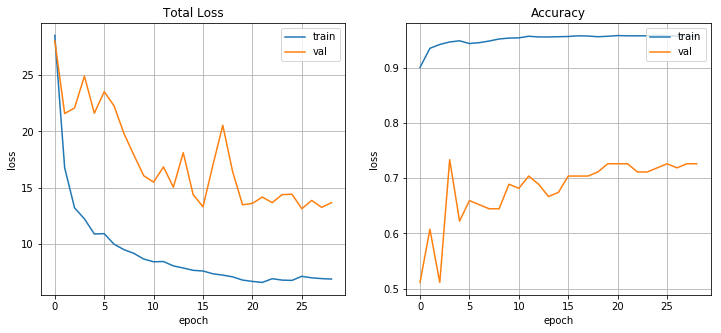

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss_list['train'], label='train')
plt.plot(loss_list['val'], label='val')
plt.legend(loc='upper right')
plt.title('Total Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.subplot(1,2,2)
plt.plot(acc_list['train'], label='train')
plt.plot(acc_list['val'], label='val')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

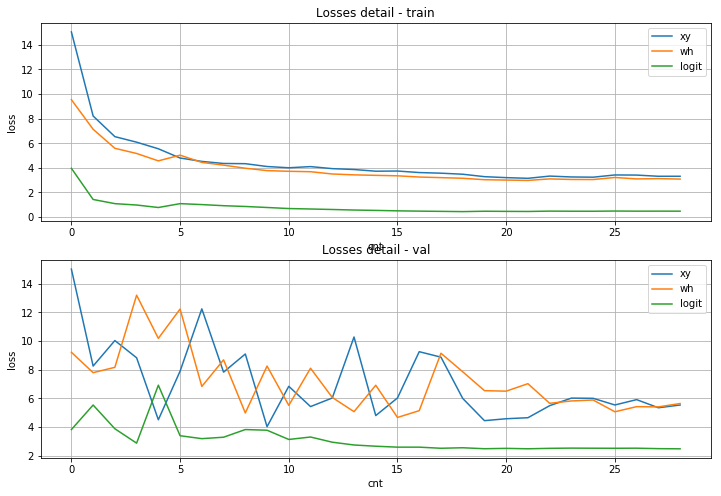

In [14]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(loss_xy_list['train'], label='xy')
plt.plot(loss_wh_list['train'], label='wh')
plt.plot(loss_logit_list['train'], label='logit')
plt.legend(loc='upper right')
plt.title('Losses detail - train')
plt.xlabel('cnt')
plt.ylabel('loss')
plt.grid()

plt.subplot(2,1,2)
plt.plot(loss_xy_list['val'], label='xy')
plt.plot(loss_wh_list['val'], label='wh')
plt.plot(loss_logit_list['val'], label='logit')
plt.legend(loc='upper right')
plt.title('Losses detail - val')
plt.xlabel('cnt')
plt.ylabel('loss')
plt.grid()
plt.show()

In [18]:
model.eval()
torch.save(model.state_dict(), 'torch_models/heatmap-4chan-1201.pth')

---
# Test

In [298]:
import matplotlib.patches as patches

my_loader_test = torch.utils.data.DataLoader(my_dataset_val, batch_size=1, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)

loader = iter(my_loader_test)
model.eval()

def cvt_yolobox(bboxes_yolo, size):
    """
    size - original [w,h]
    np.array
    yolo(cx,cy,w,h) to x,y,w,h
    """
    bboxes = bboxes_yolo.copy() # x,y,w,h

    bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*size[1] # x
    bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*size[0] # y
    bboxes[:,2] = bboxes_yolo[:,2]*size[1]
    bboxes[:,3] = bboxes_yolo[:,3]*size[0]
    bboxes = bboxes.astype(np.int)
    return bboxes

# Calc IOU
def calcIOU(box1, box2):
    """
    box - x,y,w,h
    """
    area_box1 = box1[2]*box1[3]
    area_box2 = box2[2]*box2[3]
    x1_max = max(box1[0], box2[0])
    x2_min = min(box1[0]+box1[2], box2[0]+box2[2])
    y1_max = max(box1[1], box2[1])
    y2_min = min(box1[1]+box1[3], box2[1]+box2[3])
    
    area_intersection = max(0, x2_min-x1_max) * max(0, y2_min-y1_max)
    area_union = area_box1+area_box2-area_intersection +1e-9
    return area_intersection/area_union

def box_cvt(box):
    """
    auto grad possable
    @params box - N x 4
    x,y,w,h --> x1,y1,x2,y2
    """
    box2 = box.clone().float()
    box2[:,0] = box[:,0]
    box2[:,1] = box[:,1]
    box2[:,2] = box[:,0] + box[:,2]
    box2[:,3] = box[:,1] + box[:,3]
    return box2

[AREA gt]: 0.0791
[IOU]: 0.3579
True [Pred]: 0 [GT]: 0


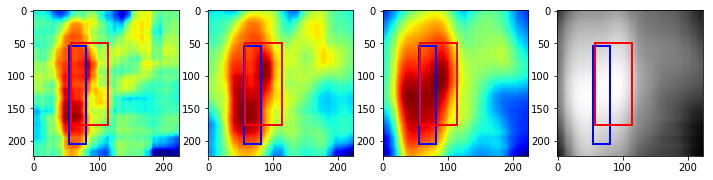

In [17]:
heatmap, box, target = loader.next()
box = box.cpu().numpy() 
print('[AREA gt]: {:.4f}'.format(box[0][2]*box[0][3]))
box = cvt_yolobox(box, heatmap.shape[-2:])
x1,y1,w1,h1 = box[0]
logit, box_adj = model(heatmap.to(model.device))
_, pred = torch.max(logit, 1)
__, label = torch.max(target, 1)
box_adj = cvt_yolobox(box_adj[:,pred.item()].detach().cpu().numpy(), heatmap.shape[-2:])
x2,y2,w2,h2 = box_adj[0]
print('[IOU]: {:.4f}'.format(calcIOU(box[0], box_adj[0])))
print(pred.item()==label.item(), '[Pred]:', pred.item(), '[GT]:', label.item())

# Create figure and axes
fig = plt.figure(figsize=(12,12))

# Display the image
for i in range(4):
    ax = fig.add_subplot(1,4, i+1)
    if(i==3): imgplot = ax.imshow(heatmap[0][pred.item()][i].cpu(), cmap='gray')
    else: 
        imgplot = ax.imshow(heatmap[0][pred.item()][i].cpu(), cmap='jet')
    #     imgplot.set_clim(0,1)

    # Create a Rectangle patch
    rect = patches.Rectangle((x1,y1),w1,h1, linewidth=2,edgecolor='b',facecolor='none')
    rect_pred = patches.Rectangle((x2,y2),w2,h2, linewidth=2,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.add_patch(rect_pred)

plt.show()

A Jupyter Widget


[IOU summary]
count    135.000000
mean       0.405937
std        0.167748
min        0.000000
25%        0.295922
50%        0.402335
75%        0.527770
max        0.867620
dtype: float64
-----------------------------
[Acc]: 0.725925925925926
[Adjusted IOU mean]: 0.32924872412406037


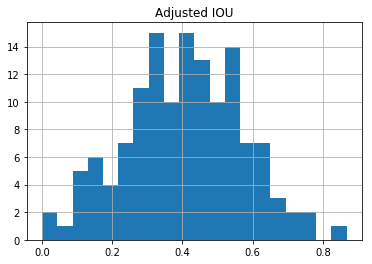

In [16]:
# show simple result
loader = iter(my_loader_test)
ious = []
labels = []
preds = []
areas_gt = []
areas_pred = []
for heatmap, box, target in tqdm(loader):
    box = box.cpu().numpy() 
    areas_gt.append(box[0][2]*box[0][3])
    box = cvt_yolobox(box, heatmap.shape[-2:])
    x1,y1,w1,h1 = box[0]
    logit, box_adj = model(heatmap.to(model.device))
    _, pred = torch.max(logit, 1)
    __, label = torch.max(target, 1)
    areas_pred.append((box_adj[0][pred.item()][2]*box_adj[0][pred.item()][3]).item())
    box_adj = cvt_yolobox(box_adj[:,pred.item()].detach().cpu().numpy(), heatmap.shape[-2:])
    x2,y2,w2,h2 = box_adj[0]
    ious.append(calcIOU(box[0], box_adj[0]))
    preds.append(pred.item())
    labels.append(label.item())
    
preds = np.array(preds)
labels = np.array(labels)
ious = np.array(ious)

areas_gt = pd.Series(areas_gt)
areas_pred = pd.Series(areas_pred)
summary = pd.Series(ious)
print('[IOU summary]')
print(summary.describe())
print('-----------------------------')
mask = preds == labels
print('[Acc]:', mask.mean())
print('[Adjusted IOU mean]:', ious[mask].sum()/len(mask))
plt.title('Adjusted IOU')
summary.hist(bins=20)
plt.show()

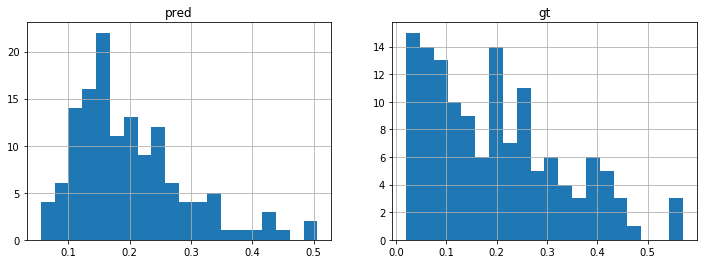

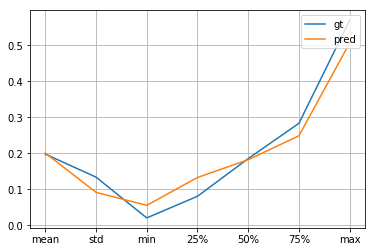

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('pred')
areas_pred.hist(bins=20)
plt.subplot(1,2,2)
plt.title('gt')
areas_gt.hist(bins=20)
plt.show()

plt.plot(areas_gt.describe()[1:], label='gt')
plt.plot(areas_pred.describe()[1:], label='pred')
plt.grid()
plt.legend(loc='upper right')
plt.show()
# areas_gt.describe()